In [1]:
import pandas as pd
from annoy import AnnoyIndex
import os
from tqdm.notebook import tqdm
import base64

from PIL import Image
from io import BytesIO
from IPython.display import HTML

NUM_FEATURES = 512
MODEL_PATH = "../../models/baseline_index.ann"

In [2]:
def get_thumbnail(path):
    i = Image.open(path).convert("RGB")
    i.thumbnail((224, 224), Image.LANCZOS)
    return i


def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, "jpeg")
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

## Load data

In [11]:
df_base = pd.read_csv("../../data/sparkrecipes_base.csv")
df_embeddings = pd.read_csv("../../data/sparkrecipes_embeddings.csv")

df_images = pd.read_csv("../../data/sparkrecipes_images.csv")
df_images = pd.melt(df_images, 
                    id_vars='recipe_id', 
                    value_vars=list(df_images.columns[1:]),
                    var_name='column', 
                    value_name='image_path').sort_values(by=["recipe_id", "column"])[["image_path"]].reset_index(drop=True)

In [175]:
df_base

,recipe_id,title,image_url,total_calories,url
0,0,Caribbean Black Beans and Rice,NaN,479.6,https://recipes.sparkpeople.com/recipe-detail....
1,1,Minestrone Soup,NaN,153.1,https://recipes.sparkpeople.com/recipe-detail....
2,2,20-Minute Chicken Creole,https://sparkpeo.hs.llnwd.net/e1/resize/630m62...,269.3,https://recipes.sparkpeople.com/recipe-detail....
3,3,Beef and Vegetable Stir-Fry,NaN,245.5,https://recipes.sparkpeople.com/recipe-detail....
4,4,Italian Vegetable Bake,https://sparkpeo.hs.llnwd.net/e1/resize/630m62...,37.2,https://recipes.sparkpeople.com/recipe-detail....
...,...,...,...,...,...
54063,54747,Slow Cooked Mexican Chicken,NaN,178.1,https://recipes.sparkpeople.com/recipe-detail....
54064,54748,Classic Chocolate Truffle Souffle Cake,https://sparkpeo.hs.llnwd.net/e1/resize/630m62...,364.5,https://recipes.sparkpeople.com/recipe-detail....
54065,54749,Mexican Shrimp coctail,NaN,52.0,https://recipes.sparkpeople.com/recipe-detail....
54066,54750,Rosemary demi-glaze,NaN,80.9,https://recipes.sparkpeople.com/recipe-detail....


In [13]:
df_embeddings

,recipe_id,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,0,1.312647,1.745611,0.024549,4.041584,0.282331,0.036875,0.214602,0.412729,2.348340,...,0.264106,0.000000,0.105781,0.000000,0.230087,0.341734,0.211301,0.220547,0.797521,0.000000
1,0,1.421376,1.250723,3.132711,0.144188,2.020523,2.047225,0.132746,0.910985,2.074128,...,2.422223,0.114516,0.764152,0.009001,0.283613,0.788782,0.584368,0.299237,5.853399,2.520212
2,0,0.137828,1.564686,0.667484,0.580247,0.069224,0.124425,0.412704,0.000000,1.201348,...,0.642398,0.661652,0.036482,0.000000,3.479456,0.154165,1.197968,1.103921,1.237342,0.618344
3,0,0.710551,1.478248,0.963002,0.000000,0.085762,0.022721,0.613554,0.312350,0.064780,...,2.035271,0.000000,0.000000,0.000000,1.013479,0.043301,2.850164,0.194671,1.380409,1.058532
4,0,0.024385,0.623414,0.007182,0.294297,0.000000,0.062329,0.367889,0.115501,0.225115,...,0.962519,0.438362,0.510686,0.000000,4.816212,0.036955,4.948285,2.772770,8.331865,1.830730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,100,0.377971,4.872329,0.575517,0.019348,0.000000,0.027056,1.188223,0.369930,0.873347,...,0.299889,0.000000,0.016181,0.000000,1.827582,0.000000,0.089033,5.332653,0.000000,0.020983
896,100,0.000000,5.397524,0.888348,2.068654,0.000000,0.562460,0.003531,0.986885,0.740844,...,0.000000,0.252174,0.058146,0.000000,0.733451,0.000000,1.381266,2.675857,0.876063,0.596842
897,100,0.159002,2.890098,0.051838,3.359712,0.013939,2.566859,0.154271,5.851393,3.710575,...,8.327135,3.743063,1.816733,1.717501,4.421910,0.036610,2.479548,2.066324,0.590810,0.811048
898,100,0.540162,1.269297,0.829861,1.629488,2.358884,1.293041,0.293311,1.226157,1.973932,...,6.990195,1.385442,0.000000,0.047327,4.372643,3.567914,0.126858,2.700228,3.486959,5.461864


In [14]:
df_images

,image_path
0,../../data/images/0/000001
1,../../data/images/0/000002
2,../../data/images/0/000003
3,../../data/images/0/000004
4,../../data/images/0/000005
...,...
895,../../data/images/100/000005
896,../../data/images/100/000006
897,../../data/images/100/000007
898,../../data/images/100/000008


In [15]:
df = df_embeddings.join(df_images).merge(df_base, on=["recipe_id"]).drop(["image_url", "url"], axis=1)
df.head()

,recipe_id,0,1,2,3,4,5,6,7,8,...,505,506,507,508,509,510,511,image_path,title,total_calories
0,0,1.312647,1.745611,0.024549,4.041584,0.282331,0.036875,0.214602,0.412729,2.348340,...,0.000000,0.230087,0.341734,0.211301,0.220547,0.797521,0.000000,../../data/images/0/000001,Caribbean Black Beans and Rice,479.6
1,0,1.421376,1.250723,3.132711,0.144188,2.020523,2.047225,0.132746,0.910985,2.074128,...,0.009001,0.283613,0.788782,0.584368,0.299237,5.853399,2.520212,../../data/images/0/000002,Caribbean Black Beans and Rice,479.6
2,0,0.137828,1.564686,0.667484,0.580247,0.069224,0.124425,0.412704,0.000000,1.201348,...,0.000000,3.479456,0.154165,1.197968,1.103921,1.237342,0.618344,../../data/images/0/000003,Caribbean Black Beans and Rice,479.6
3,0,0.710551,1.478248,0.963002,0.000000,0.085762,0.022721,0.613554,0.312350,0.064780,...,0.000000,1.013479,0.043301,2.850164,0.194671,1.380409,1.058532,../../data/images/0/000004,Caribbean Black Beans and Rice,479.6
4,0,0.024385,0.623414,0.007182,0.294297,0.000000,0.062329,0.367889,0.115501,0.225115,...,0.000000,4.816212,0.036955,4.948285,2.772770,8.331865,1.830730,../../data/images/0/000005,Caribbean Black Beans and Rice,479.6


In [16]:
df.shape

(900, 516)

## Build ANN Index

In [17]:
embeddings = df.iloc[:, -515:-3].values
embeddings

array([[1.31264687, 1.74561143, 0.02454863, ..., 0.22054689, 0.79752135,
        0.        ],
       [1.42137551, 1.25072253, 3.13271093, ..., 0.29923689, 5.8533988 ,
        2.52021194],
       [0.13782763, 1.56468606, 0.66748434, ..., 1.10392106, 1.23734176,
        0.61834359],
       ...,
       [0.15900186, 2.89009762, 0.05183767, ..., 2.06632352, 0.59081   ,
        0.81104827],
       [0.54016191, 1.26929736, 0.82986087, ..., 2.70022774, 3.48695874,
        5.46186399],
       [0.03748924, 4.28906631, 0.37523779, ..., 0.69676858, 0.        ,
        1.06656206]])

In [215]:
!rm $MODEL_PATH

In [216]:
annoy_index = AnnoyIndex(NUM_FEATURES, metric='angular')
if os.path.isfile(MODEL_PATH):
    annoy_index.load(MODEL_PATH)
else:
    for i, f in tqdm(enumerate(embeddings), total=embeddings.shape[0]):
        annoy_index.add_item(i, f)

    annoy_index.build(10000)
    annoy_index.save(MODEL_PATH)

In [226]:
NUMBER_NEAREST = 5

nearest, distances = annoy_index.get_nns_by_vector(embeddings[6], NUMBER_NEAREST, include_distances=True)

In [227]:
df_nearest = df[["image_path", "total_calories"]].iloc[nearest]

In [228]:
distances

[0.00020249135559424758,
 0.6299389004707336,
 0.6339552998542786,
 0.6372992396354675,
 0.6483837366104126]

,image_path,total_calories
6,,479.6
60,,148.9
165,,331.5
592,,202.7
444,,186.6

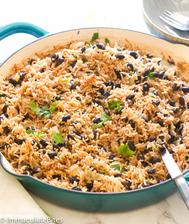
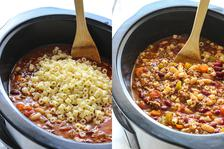
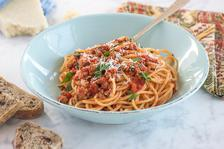
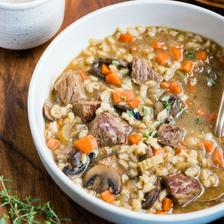
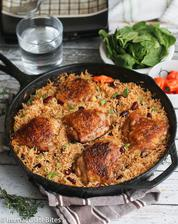

In [229]:
HTML(df_nearest.to_html(formatters={**{f"image_path": image_formatter}}, escape=False))

In [230]:
df_nearest.iloc[1:].describe()

,total_calories
count,4.000000
mean,217.425000
std,79.321682
min,148.900000
25%,177.175000
50%,194.650000
75%,234.900000
max,331.500000
